# HR monitor during physical exercise 
Implement of these paper:
</br>
Denosing using wiener filter:
[Accurate Heart Rate Monitoring During Physical Exercises Using PPG
](https://ieeexplore.ieee.org/document/7867772)
</br>
Measure HR more accurate:
[Finite State Machine Framework with Crest Factor and HR Change](https://ieeexplore.ieee.org/document/8468028)


## import library

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.signal as signal
from scipy.interpolate import interp1d
import re
import pandas as pd
import math

plt.style.use('ggplot')

sys.path.insert(0, os.path.abspath('lib'))
import file_read
import sig_proc as sp
import ecg

def check_var(a_variable):
    is_global = a_variable in globals()
    return is_global

def RMS_amp(data):
    squaredData = []
    for val in data:
        squaredData.append(val**2)
    
    ms = np.mean(squaredData)
    rms = math.sqrt(ms)
    return rms

def downsample(data, nth):
    newdata = []
    for i in range(0, len(data), nth):
        newdata.append(data[i])
    return newdata



#------------------------------------
import ECGHR

ecg_sr = 500

def IQR(data):
    Q1 = np.quantile(data ,0.25)
    Q3 = np.quantile(data, 0.75)
    IQR = Q3-Q1

    remove_outlier = []
    for y in data:
        if y> 30 and y <240:
            if y> Q1-1.5*IQR and y<Q3+1.5*IQR:
                remove_outlier.append(y)
    return remove_outlier

def max_psd_freq(psd, freqs, rangeIdx=[]):
    if rangeIdx == []:
        rangeIdx = range(len(psd)-1)
    candidates_idx = []
    for i in rangeIdx[1:-1]:
        p_current = psd[i] - psd[i-1]
        p_next = psd[i+1] - psd[i]
        if p_current > 0 and p_next < 0:
            candidates_idx.append(i)

    if candidates_idx !=[]:
        max_idx = candidates_idx[np.argmax(psd[candidates_idx])] 
        dom_freq = freqs[max_idx]
    else:
        max_idx = None
        dom_freq = None
    return max_idx, dom_freq

class Dom_freq:
    def __init__(self, PSD, freqs_range):
        self.PSD = PSD
        self.freqs_range = freqs_range
        
    def find_peak(self, rangeIdx='None'):
        indexList = []
        if rangeIdx == 'None':
            rangeIdx = range(len(self.PSD)-1)
        for i in rangeIdx[1:]:
            p_current = self.PSD[i] - self.PSD[i-1]
            p_next = self.PSD[i+1] - self.PSD[i]
            if p_current > 0 and p_next < 0:
                indexList.append(i)
        return indexList
    
    # Find maximum peak on spectrogram
    def HR_EST(self):
        candidates_idx = self.find_peak()
        max_idx = candidates_idx[np.argmax(self.PSD[candidates_idx])]
    
        bpm = np.round(self.freqs_range[max_idx]*60,4)
        return bpm
    
    # Track previous HR on power spectrum. 
    # Take clossest peak of previous HR on power spectrum as current HR
    def track_pre_HR(self, HR_pre):
        candidates_idx = self.find_peak()
        clossest_idx = np.argmin(abs(self.freqs_range[candidates_idx]*60-HR_pre))
        nearest_index = candidates_idx[clossest_idx]
        return freqs_range[nearest_index]*60
    
class FSM:
    def __init__(self, CF_thr=4, HR_change_2s=5):
        self.CF_thr = CF_thr
        self.HR_change_2s = HR_change_2s
        self.cn_alert = 0
        self.cn_uncertain = 0
        self.cn_recovery = 0
        # Transition times of each state
        self.N_alert = 5
        self.N_uncertain= 3
        self.N_recovery = 4
        
    def RMS_amp(self, data):
        squaredData = []
        for val in data:
            squaredData.append(val**2)
        ms = np.mean(squaredData)
        rms = math.sqrt(ms)
        return rms
    
    # Crest factor
    def crest_factor(self, PSD):
        return max(PSD)/ self.RMS_amp(PSD)
    
    def transition(self, PSD, cnt, previous_state, HR_change):
        CF = self.crest_factor(PSD)
        if cnt == 0:
            # entering FSM 
            if CF > self.CF_thr:
                current_state = 'stable'
            else: 
                current_state = 'alert'
                self.cn_alert +=1
        else:
            # stable state
            if previous_state == 'stable':
                if CF > self.CF_thr and HR_change < self.HR_change_2s:
                    # i_last = t2 # represents the latest time when the state was in stable state
                    current_state = 'stable'
                else: 
                    current_state = 'alert'
                    self.cn_alert +=1
                    
            # alert state
            if previous_state == 'alert':
                if CF < self.CF_thr:
                    if self.cn_alert < self.N_alert:
                        self.cn_alert +=1
                        current_state = 'alert'
                    else:
                        self.cn_alert =0
                        self.cn_uncertain +=1
                        current_state = 'uncertain'
                else:
                    self.cn_alert = 0
                    self.cn_recovery+=1
                    current_state = 'recovery'
                    
            # recovery state
            if previous_state == 'recovery':
                if CF < self.CF_thr:
                    self.cn_recovery = 0
                    self.cn_alert +=1
                    current_state = 'alert'
                elif CF > self.CF_thr and self.cn_recovery < self.N_recovery:
                    self.cn_recovery +=1
                    current_state = 'recovery'
                elif CF > self.CF_thr and HR_change < self.HR_change_2s and self.cn_recovery >= self.N_recovery:
                    self.cn_recovery = 0
                    
                    current_state = 'stable'
            # uncertain state
            if previous_state =='uncertain':
                if CF < self.CF_thr:
                    self.cn_uncretain = 0
                    current_state = 'uncertain'
                else:
                    if self.cn_uncertain < 3:
                        self.cn_uncertain +=1
                        current_state = 'uncertain'
                    elif self.cn_uncertain == self.N_uncertain:
                        self.cn_uncertain =0
                        self.cn_alert +=1
                        current_state = 'alert'
        return current_state
    
class post_process:
    def __init__(self, HR_list, change_limit=2, buffer_len=5):
        self.change_limit = change_limit
        self.BL= buffer_len
        self.HR_list = HR_list
    def smooth(self, HR_est, cnt):
        if cnt == 0:
            self.HR_list[cnt] = HR_est
        else:
            self.HR_list[cnt] = np.mean(np.append([HR_est] , self.HR_list[max(0,cnt-self.BL):cnt]))
    
    # only smooth the output value 
    def post_v2(self, HR_est, cnt, current_state):
        if (current_state == 'alert' or current_state == 'uncertain'):
            if cnt > 0:
                if self.HR_list[cnt-1] - HR_est > self.change_limit:
                    HR_post = self.HR_list[cnt-1] - self.change_limit
                elif self.HR_list[cnt-1] - HR_est < - self.change_limit:
                    HR_post = self.HR_list[cnt-1] + self.change_limit
                else:
                    HR_post = HR_est
                self.HR_list[cnt] = HR_post
            else:
                self.HR_list[cnt] = HR_est

        # stable and recovery state
        else:
            if cnt >= self.BL:
                # combine prediction and current estimation
                ddd = np.polyfit(np.arange(self.BL), self.HR_list[max(cnt-self.BL,0):cnt], 1)
                p = np.poly1d(ddd) 
                W = 0.3
                self.HR_list[cnt] = W*p(self.BL+1) +(1-W)*HR_est # predict next HR
            else: 
                self.HR_list[cnt] = HR_est
        
        
    # smooth all HR in list
    def post_v1(self, HR_est, cnt, current_state):
        if (current_state == 'alert' or current_state == 'uncertain'):
            if cnt > 0:
                if self.HR_list[cnt-1] - HR_est > self.change_limit:
                    HR_post = self.HR_list[cnt-1] - self.change_limit
                elif self.HR_list[cnt-1] - HR_est < - self.change_limit:
                    HR_post = self.HR_list[cnt-1] + self.change_limit
                else:
                    HR_post = HR_est
                self.smooth(HR_est, cnt)
            else:
                self.HR_list[cnt] = HR_est

        # stable and recovery state
        else:
            if cnt >= self.BL:
                # combine prediction and current estimation
                ddd = np.polyfit(np.arange(self.BL), self.HR_list[max(cnt-self.BL,0):cnt], 1)
                p = np.poly1d(ddd) 
                W = 0.3
                self.HR_list[cnt] = W*p(self.BL+1) +(1-W)*HR_est # predict next HR
            else: 
                self.HR_list[cnt] = HR_est
                


In [35]:
freqs = np.fft.rfftfreq(n_fft, 1/25)
CutoffFreqHP = 1 #60 BPM
CutoffFreqLP = 3 # 180 BPM
lowR = np.argmin(abs(freqs-1)) # 60 PBM
highR = np.argmin(abs(freqs-3)) # 180 PBM
freqs_range = freqs[lowR:highR]
print(len(freqs_range))


82


# Main

to-do : packing each algorithm for test

In [84]:

folder = 'Thor 2.0 動態心律收集_0301'
subject = 'Rick'
act_type = 'climb'

ext = '.csv'

#------------------------------------------------------------
# Read PPG
PPG_fileName =  subject+ '_PPG_' + act_type + ext
PPG_filePath = os.path.join('../data', folder, subject, PPG_fileName)


PPG_DATA = file_read.readcsv3(PPG_filePath)

PPG1 = PPG_DATA['G1']
PPG2 = PPG_DATA['G2']
ACC_X = PPG_DATA['accX']
ACC_Y = PPG_DATA['accY']
ACC_Z = PPG_DATA['accZ']
acc_scalar = PPG_DATA['acc']

#---------------------------------------------------------------
# Overall parameters
sr = 50
b_filtParam, a_filtParam = signal.butter(4, [0.8/(sr/2), 3/(sr/2)], btype='band', analog=False)
WFlength = 15 # Wiener filter length, user tunable param
n_fft = 1024

cn_track = 0

# --------------------------------------------------------------
# sampling
window = 6 *sr
step_sec = 2
step = step_sec*sr
windowNb = int((len(PPG2)-window)/step) + 1


# initial list
filtered_PPG =np.zeros((windowNb, int(window)))
PPG_AVE_LIST = np.zeros((windowNb, int(window)))
W1_FFTi = np.zeros((windowNb, 82)) 
W2_FFTi = np.zeros((windowNb, 82)) 
PPG_FFT_list = np.zeros((windowNb, 82)) 
PPG_FFT_FIN = np.zeros((windowNb, 82)) 

# Version of each HR estimation method
HR_est_list = np.zeros(windowNb) # estimation on denoise PSD
HR_obs_list = np.zeros(windowNb) # observe 
HR_est_post_list = np.zeros(windowNb) 

HR_mix_list = np.zeros(windowNb)
HR_mix_post_list = np.zeros(windowNb)
HR_mix_post_smooth_list = np.zeros(windowNb)

HR_near_list = np.zeros(windowNb) # Find the nearest previous HR
HR_near_smooth_list = np.zeros(windowNb)
HR_track_list = np.zeros(windowNb) # Andtom method

crest_factor = np.zeros(windowNb)
state = ['' for x in range(windowNb)]

# FSM initial
FSM_INSTANCE = FSM(CF_thr=6, HR_change_2s=5)

# post process 
EST_POST = post_process(HR_est_post_list)
MIX_POST = post_process(HR_mix_post_list)

for n in range(windowNb):
    
    s1 = n*step
    s2 = s1 + window

    PPG1_seg = PPG1[s1:s2]
    PPG2_seg = PPG2[s1:s2]
    ACC_X_seg = ACC_X[s1:s2]
    ACC_Y_seg = ACC_Y[s1:s2]
    ACC_Z_seg = ACC_Z[s1:s2]
    
    
    #------------------------------------------------------------
    # Signal Preprocessing
    # G2 preprocess
    filt_G1 = signal.filtfilt(b_filtParam, a_filtParam, PPG1_seg)
    filt_G2 = signal.filtfilt(b_filtParam, a_filtParam, PPG2_seg)

    filt_G1_norm = sp.z_score(filt_G1)
    filt_G2_norm = sp.z_score(filt_G2)
    
    filt_ACC_X = signal.filtfilt(b_filtParam, a_filtParam, ACC_X_seg)
    filt_ACC_Y = signal.filtfilt(b_filtParam, a_filtParam, ACC_Y_seg)
    filt_ACC_Z = signal.filtfilt(b_filtParam, a_filtParam, ACC_Z_seg)



    #------------------------------------------------------------
    # Spectra Analylize
    PPG_AVE = (filt_G1_norm + filt_G2_norm)/2
    PPG_AVE_LIST[n] = PPG_AVE
    
    # downsample to 25Hz
    PPG_AVE = downsample(PPG_AVE, 2)
    filt_ACC_X = downsample(filt_ACC_X, 2)
    filt_ACC_Y = downsample(filt_ACC_Y, 2)
    filt_ACC_Z = downsample(filt_ACC_Z, 2)
    down_sr = 25 # new sample rate
    
    # Observed power spectrum
    # fxx, PPG_FFT = signal.welch(x=PPG_AVE, fs=1/down_sr, nfft=n_fft, scaling='density')

    PPG_FFT = np.abs(np.fft.rfft(PPG_AVE, n_fft)) # Only process real part of fft 
    freqs = np.fft.rfftfreq(n_fft, 1/down_sr)
    
    ACC_X_FFT = np.abs(np.fft.rfft(filt_ACC_X, n_fft))
    ACC_Y_FFT = np.abs(np.fft.rfft(filt_ACC_Y, n_fft))
    ACC_Z_FFT = np.abs(np.fft.rfft(filt_ACC_Z, n_fft))

    # Getting rid of most spectra outsid the range of interest 
    CutoffFreqHP = 1 #60 BPM
    CutoffFreqLP = 3 # 180 BPM
    lowR = np.argmin(abs(freqs-1)) # 60 PBM
    highR = np.argmin(abs(freqs-3)) # 180 PBM
    freqs_range = freqs[lowR:highR]
    
    PPG_FFT = PPG_FFT[lowR:highR]
    PPG_FFT_list[n] = PPG_FFT
    ACC_X_FFT = ACC_X_FFT[lowR:highR]
    ACC_Y_FFT = ACC_Y_FFT[lowR:highR]
    ACC_Z_FFT = ACC_Z_FFT[lowR:highR]
    

    # HR_obs_list[n] = freqs_range[np.argmax(PPG_FFT)]*60
    
    #-------------------------------------------------------
    # Apply wiener filter
    WC1 = WFlength
    WC2 = WFlength
    
    # Wiener 1 
    W1_FFTi[n] = abs(PPG_FFT)/max(abs(PPG_FFT))
    if n == 0:
        W1_PPG_FFT_ALL = W1_FFTi[n]
    else:
        W1_PPG_FFT_ALL = np.mean(W1_FFTi[max(0,n-WC1):n],0)
    W1_PPG_FFT_ALL_norm = np.array((W1_PPG_FFT_ALL)/max(W1_PPG_FFT_ALL))
    W1_ACC_X_FFT_norm = np.array((abs(ACC_X_FFT))/max(abs(ACC_X_FFT)))
    W1_ACC_Y_FFT_norm = np.array((abs(ACC_Y_FFT))/max(abs(ACC_Y_FFT)))
    W1_ACC_Z_FFT_norm = np.array((abs(ACC_Z_FFT))/max(abs(ACC_Z_FFT)))
    WF1 = (1 - 1/3*(W1_ACC_X_FFT_norm+W1_ACC_Y_FFT_norm+W1_ACC_Z_FFT_norm)/(W1_PPG_FFT_ALL_norm)); 
    WF1 = np.where(WF1<0,-1, WF1)
    W1_PPG_FFT_Clean=abs(PPG_FFT)*WF1
    
    
    # Wiener 2
    W2_FFTi[n] = abs(PPG_FFT)/max(abs(PPG_FFT))
    if n==0:
        W2_PPG_FFT_ALL = W2_FFTi[n]
    else:
        W2_PPG_FFT_ALL = np.mean(W2_FFTi[max(0,n-WC2):n], 0)
        
    W2_PPG_FFT_ALL_norm = np.array((W2_PPG_FFT_ALL)/max(W2_PPG_FFT_ALL))
    W2_ACC_X_FFT_norm = np.array((abs(ACC_X_FFT))/max(abs(ACC_X_FFT)))
    W2_ACC_Y_FFT_norm = np.array((abs(ACC_Y_FFT))/max(abs(ACC_Y_FFT)))
    W2_ACC_Z_FFT_norm = np.array((abs(ACC_Z_FFT))/max(abs(ACC_Z_FFT)))
    WF2 = W2_PPG_FFT_ALL_norm/(((W2_ACC_X_FFT_norm+W2_ACC_Y_FFT_norm+W2_ACC_Z_FFT_norm)/3)+W2_PPG_FFT_ALL_norm) 
    W2_PPG_FFT_Clean = abs(PPG_FFT)*WF2;
    W2_FFTi[n] = (W2_PPG_FFT_Clean)/max(W2_PPG_FFT_Clean);
    
    W1_PPG_FFT_Clean = W1_PPG_FFT_Clean/np.std(W1_PPG_FFT_Clean)
    W2_PPG_FFT_Clean = W2_PPG_FFT_Clean/np.std(W2_PPG_FFT_Clean)

    PPG_FFT_FIN[n] = W1_PPG_FFT_Clean+ W2_PPG_FFT_Clean # ensambling W1 & W2

 
    #------------------------------------------------------
    # Dominant frequency on periodogram
    OBS_INSTANCE = Dom_freq(PPG_FFT, freqs_range)
    HR_obs = OBS_INSTANCE.HR_EST()
    HR_obs_list[n] = HR_obs 
    # if n==0:
    #     HR_obs_list[n] = HR_obs 
    # else:
    #     HR_obs_list[n] = np.mean(HR_obs_list[max(0, n-5): n])

    # Dominant frequency on DeNoise periodogram
    DN_INSTANCE = Dom_freq(PPG_FFT_FIN[n], freqs_range)
    
    HR_est = DN_INSTANCE.HR_EST()
    HR_est_list[n] = HR_est
    # ---------------------------------------------------------
    # mix version
    if n == 0:
        HR_est_pre = HR_est
    
    #Find closest index of PSD to the last HR 
    
    HR_est_near =  DN_INSTANCE.track_pre_HR(HR_est_pre)
    HR_near_list[n]=HR_est_near
    HR_near_smooth_list[n] = np.mean(HR_near_list[max(0,n-5):n])
    
    HR_mix = 0.5* (HR_est_near + HR_est)
    HR_mix_list[n] = HR_mix
    #------------------------------------------------------------
    # FSM
    
    if n==0:
        current_state = 'initial'
        HR_change = 0
        cs = ''
        hr_ch = 0
    else:
        HR_change = HR_est_list[n] - HR_est_list[n-1]
        hr_ch = HR_obs_list[n] - HR_obs_list[n-1]
    current_state = FSM_INSTANCE.transition(PSD=PPG_FFT_FIN[n], cnt=n, previous_state=current_state, HR_change=HR_change)
    cs = FSM_INSTANCE.transition(PSD=PPG_FFT_list[n], cnt=n, previous_state=cs, HR_change=hr_ch)

    crest_factor[n] = FSM_INSTANCE.crest_factor(PPG_FFT_FIN[n])
    
    state[n] = cs
    

    #---------------------------------------------------------
    # Post processing
    EST_POST.post_v1(HR_est, n, current_state) # update HR_est_post_list
    MIX_POST.post_v2(HR_mix, n, current_state) # update HR_mix_post_list

    if n >0:
        HR_mix_post_smooth_list[n] = np.mean(HR_mix_post_list[max(0,n-5):n])
    else:
        HR_mix_post_smooth_list[n] = HR_est
    
    HR_est_pre = HR_mix_post_smooth_list[n]


    
    #---------------------------------------------------
    # History Tracking
    HR_track_list[n] = HR_est
    hist_int= 25 # We start with +- 25 BPM history tracking window
    if n> 15:
        hist_int = max(abs(np.diff(HR_track_list[0:n])))+5

    # --------------------------------------------------    
    # HR estimation
    freq_res = freqs[1] - freqs[0]
    
    if n==0:        
        max_idx , dom_freq= max_psd_freq(PPG_FFT_FIN[n], freqs_range)
        HR_track_list[n] = dom_freq*60

        lower_bound = max(0, max_idx - int((hist_int/(freq_res*60))+0.5))
        upper_bound = min(len(freqs_range) ,max_idx + int((hist_int/(freq_res*60)) + 0.5))
        rangeIdx = np.arange(lower_bound, upper_bound)
    else:
        max_idx , dom_freq= max_psd_freq(PPG_FFT_FIN[n], freqs_range, rangeIdx)        
        if max_idx ==None:
            HR_track_list[n] = HR_track_list[n-1]
        else:
            HR_track_list[n] = dom_freq*60
            
        # if n==4:
        #     plt.plot(PPG_FFT_FIN[n])
        #     plt.plot(max_idx, PPG_FFT_FIN[n][max_idx], '*')
        #     print('max freq:{}'.format(freqs_range[max_idx]))
        #     print("lower_bound:{}, upper_bound:{}".format(lower_bound, upper_bound))
        lower_bound = max(0, max_idx - int((hist_int/(freq_res*60))+0.5)) 
        upper_bound = min(len(freqs_range) ,max_idx + int((hist_int/(freq_res*60)) + 0.5))
        rangeIdx = np.arange(lower_bound, upper_bound)
        
        
    # Mild smoothing with linear regression prediction
    # if n>=5 and abs(HR_track_list[n]-HR_track_list[n-1]>5):
    #     ddd = np.polyfit(np.arange(5), HR_track_list[n-5:n], 1)
    #     p = np.poly1d(ddd)
    #     HR_track_list[n] = 0.8*HR_track_list[n]+0.2*p(5)
    # else:
    #     HR_track_list[n] = HR_est
    

C:\Users\10712064\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\10712064\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\10712064\AppData\Local\Continuum\anaconda3\envs\Thor2\lib\site-packages\ipykernel_launcher.py:56: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


## HR estimation result

Jason


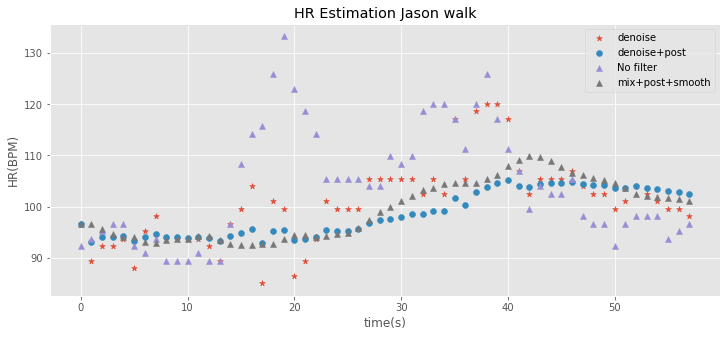

In [37]:

plt.figure(figsize=(12,5))
plt.title("HR Estimation " + subject +' ' +act_type)
plt.scatter(np.arange(windowNb), HR_est_list, marker="*", label="DN")
plt.scatter(np.arange(windowNb), HR_est_post_list, marker='o', label="DN+post")
plt.scatter(np.arange(windowNb), HR_obs_list, marker="^", label="No filter")
# plt.scatter(np.arange(windowNb), HR_mix_post_list, marker='^', label="mix post")
plt.scatter(np.arange(windowNb), HR_mix_post_smooth_list, marker='^', label="mix+post+smooth")

plt.ylabel("HR(BPM)")
plt.xlabel("time(s)")
plt.legend(loc="best")
print(subject)

figureName = '../figure/HR Estimation ' + subject + ' ' + act_type +'.png'
# plt.savefig(figureName)


# Read ECG


In [85]:

#------------------------------------------------------------
# Read ECG
ECG_fileName =  subject+ '_ECG_' + act_type + ext
ECG_filePath = os.path.join('../data', folder, subject ,ECG_fileName)

ECG_DATA = file_read.readcsv_ECG(ECG_filePath)

lead1 = ECG_DATA['lead1']

ecg_window= 6 *ecg_sr
ecg_step = step_sec*ecg_sr
ecg_windowNb = int((len(lead1)-ecg_window)/ecg_step) + 1

ecg_hr_list = np.zeros(ecg_windowNb)
ecg_list = np.zeros((ecg_windowNb, ecg_window))
# ecg_list = np.zeros((ecg_windowNb, 2935))


for n in range(ecg_windowNb):
    s1 = n*ecg_step
    s2 = s1 + ecg_window
    ecg_current = lead1[s1:s2]
    # Rick's method
    
    ecg_proc = ecg.ecg_preprocess(ecg_current, ecg_sr)
    ecg_proc = np.array(ecg_proc)
    ecg_hr, rpeak= ecg.ecg_hr_estimate(ecg_proc, ecg_sr)
    filt_ecg = np.array(ecg.final_filter(ecg_current, ecg_sr, 4))
    ecg_list[n] = filt_ecg
    ecg_hr_list[n] = np.mean(ecg_hr)


## Plot ECG and PPG result

(40.0, 240.0)

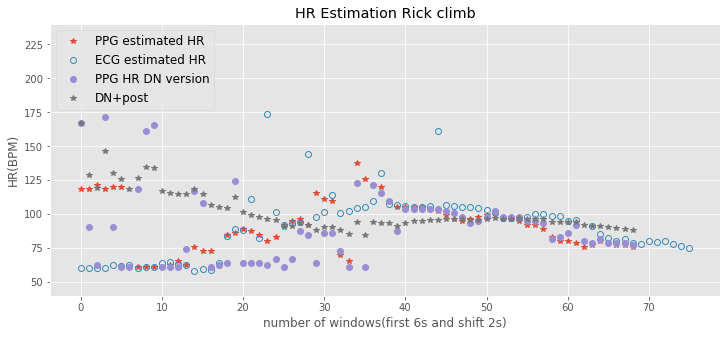

In [92]:

# generate time-axis
PPG_timeAxis = np.arange(0, windowNb*2, step_sec)
ECG_timeAxis = np.arange(0, ecg_windowNb*2, step_sec)

plt.figure(figsize=(12,5))
plt.title("HR Estimation " + subject +' '+ act_type)
plt.plot(np.arange(windowNb), HR_obs_list, "*", label="PPG estimated HR")
plt.plot(np.arange(ecg_windowNb), ecg_hr_list, "o",markerfacecolor='none', label="ECG estimated HR", )
plt.plot(np.arange(windowNb), HR_est_list, "o", label="PPG HR DN version", )
plt.plot(np.arange(windowNb), HR_est_post_list, "*", label="DN+post", )
# plt.plot(np.arange(windowNb), HR_obs_list, "*", label="None", )
# plt.plot(np.arange(windowNb), HR_mix_post_smooth_list, "^", label="PPG HR mix smooth version", )
# plt.plot(np.arange(windowNb), HR_track_list, "^", label="AndTem method", )
# plt.plot(np.arange(windowNb), HR_near_list, "^", label="PPG HR (closet to the pre peak)" )


# plt.plot(np.arange(windowNb), HR_track_list, "^", label="HR tracking")
# plt.plot(PPG_timeAxis, HR_obs_list, "^", label="maximum peak")

# for n in range(windowNb):
#     if state[n] == 'uncertain':
#         plt.axvline(n, color='red', ls=':')
#     if state[n] == 'alert':
#         plt.axvline(n, color='darkorange', ls=':')
#     if state[n] == 'recovery':
#         plt.axvline(n, color='green', ls=':')
#     if state[n] == 'stable':
#         plt.axvline(n, color='blue', ls=':')

plt.ylabel("HR(BPM)")
plt.xlabel("number of windows(first 6s and shift 2s)")
plt.legend(loc="best", fontsize=12)
plt.ylim(40,240)
# plt.savefig('../figure/denoise/HR' + fileName+  ' ' + act_type +'.png')
# plt.axvline(18)


In [40]:
# calculate MAE

def MAE(x,y):
    AE = []
    l = min(len(x), len(y))
    for i in range(l):
        AE.append(np.abs(x[i] - y[i]))
    return np.mean(AE)

def exclude_state(x, y, state):
    # exclude uncertain state|
    ecg_hr = []
    ppg_hr = []
    for i in range(windowNb):
        if state[i] != 4:
            ecg_hr.append(ecg_hr_list[i])
            ppg_hr.append(HR_est_list[i])
    return MAE(ecg_hr, ppg_hr)
    
MAE1 = MAE(ecg_hr_list, HR_est_list) # denoise using WIener filter
MAE2 = MAE(ecg_hr_list, HR_valid_list) # add linear regression
MAE3 = exclude_state(ecg_hr_list, HR_est_list, state) # exclude uncertain state
MAE4 = MAE(ecg_hr_list, HR_obs_list) # Dominant peak on observed PSD
MAE6 = MAE(ecg_hr_list, HR_mix_valid_smooth_list)

print(fileName + ' ' + act_type)
print('HR MAE(No filter): ', np.around(MAE4,4))
print('HR MAE(valid): ', np.around(MAE2,4))
print('HR MAE(smooth mix): ', np.round(MAE6,4))

NameError: name 'HR_valid_list' is not defined



<div class="heatMap">

| subject/Test param | valid  | valid mix| mix smooth3| DN valid | DN mix |
|        ----        | ----   |  ----    |  ----      |  ----    | ----   |
| Coco walk          | 8.9656 | 11.1881  | 11.0371    |  12.7532 | 12.3257|
| Coco stair         | 27.2567| 25.3951  | 27.5616    |  29.7182 | 29.8241|
| Rick walk          | 6.3789 | 8.4491   |  9.435     |  7.01    | 7.3216 |
| Rick stair         | 9.0759 | 4.7048   |  5.5364    |  11.968  | 8.8964 |
| Shawn walk         | 14.4439| 11.6337  |  14.0465   | 17.122   | 16.4695|
| Shawn stair        | 33.5533|  21.1208 |  20.3524   | 
</div>

<style>
.heatMap {
    width: 70%;
    text-align: center;
}
.heatMap th {
background: grey;
word-wrap: break-word;
text-align: center;
}
/* .heatMap tr:nth-child(2) { background: #E24A33; } */
/* .heatMap tr:nth-child(4) { background: #348ABD; } */

/* palette
#E24A33
#348ABD
#988ED5
#777777
#FBC15E
#8EBA42
#FFB5B8 
*/

</style>


# Data glimpse

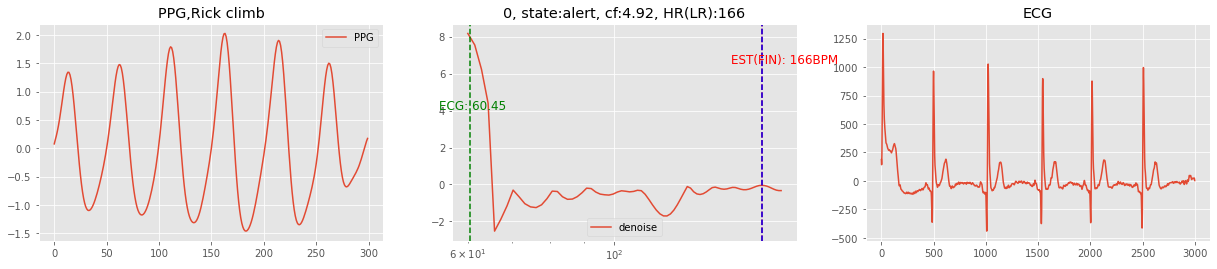

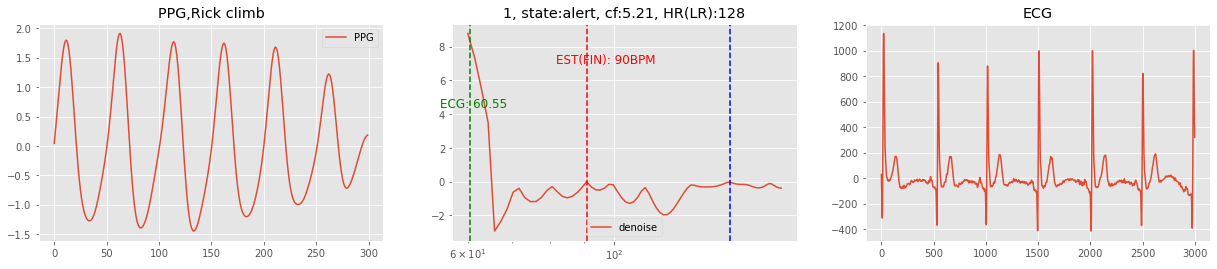

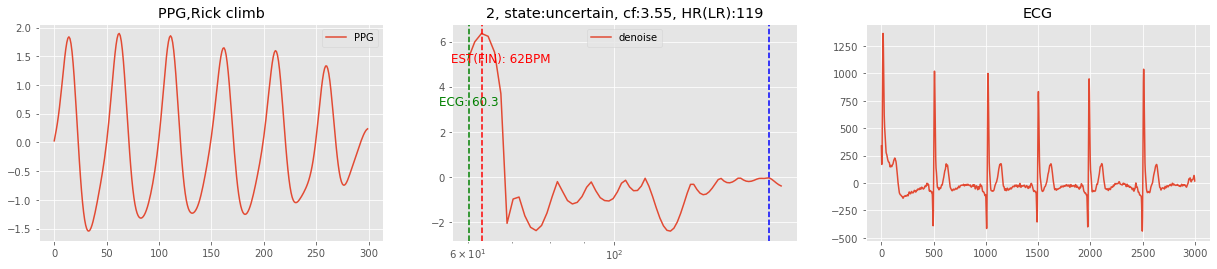

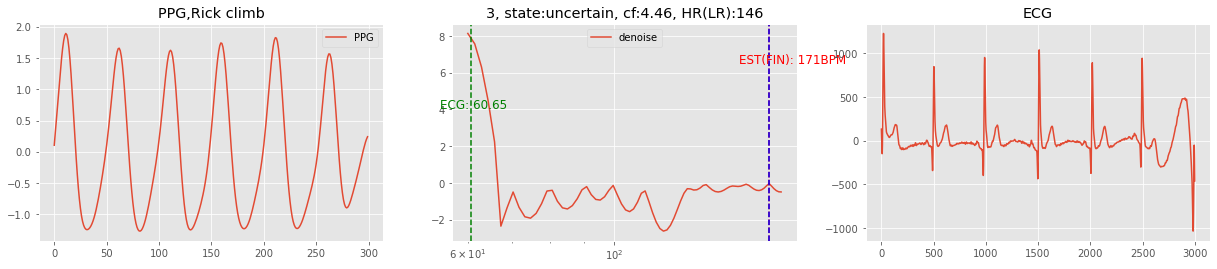

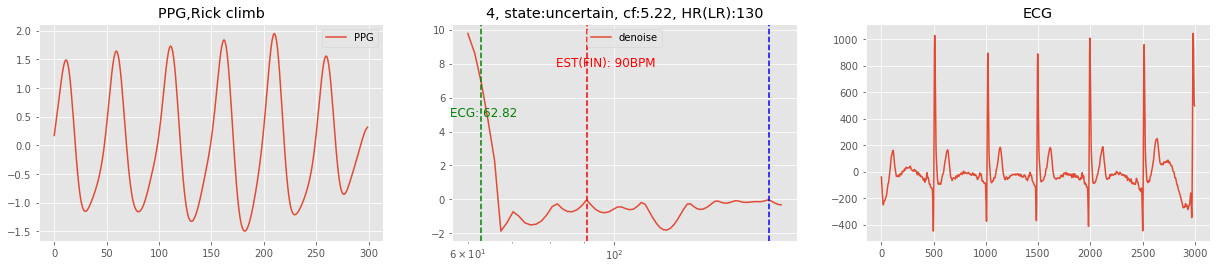

In [93]:
for n in range(0,5):
    fig = plt.figure(figsize = (21 ,4))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    # ------------------------------------------
    # Plot PPG
    ax1.set_title('PPG,'+ subject + ' ' + act_type)
    # ax1.plot(filtered_PPG[n], label='G2')
    ax1.plot(PPG_AVE_LIST[n], label='PPG')
    ax1.legend()
    
    
    # PPG_FFT_norm = abs(PPG_FFT[n])/max(abs(PPG_FFT[n]))
    fig_title = str(n) + ', state:' + str(state[n]) + ', cf:' + str(np.round(crest_factor[n],2)) + ', HR(LR):' + str(int(HR_est_post_list[n]))
    ax2.set_title(fig_title)
    ax2.semilogx(freqs_range*60, PPG_FFT_FIN[n], label="denoise")
    # ax2.semilogx(freqs_range*60, PPG_FFT[n], label="observed")
    ax2.legend()
    ax2.axvline(HR_est_list[n], color='red', ls='--')
    ax2.text(HR_est_list[n]*0.9, max(PPG_FFT_FIN[n])*0.8 , 'EST(FIN): ' + str(int(HR_est_list[n])) + 'BPM', fontsize=12, c='red')
    
    #-------------------------------------------------    
    # plot dominant peak on PPG_FFT
    # ax2.axvline(HR_est_post_list[n], color='blue', ls='--')
    # ax2.text(HR_est_post_list[n]*0.9, max(PPG_FFT_FIN[n])*0.7 , 'EST: ' + str(np.round(HR_est_post_list[n], 2)), fontsize=12, c='blue')
    
    # plot ECG HR on PPG_FFT
    ax2.axvline(ecg_hr_list[n], color='green', ls='--')
    ax2.text(ecg_hr_list[n]*0.9, max(PPG_FFT_FIN[n])*0.5 , 'ECG: ' + str(np.round(ecg_hr_list[n], 2)), fontsize=12, c='green')    
    
    ax2.axvline(HR_track_list[n], color='blue', ls='--')

        
    
    # ax2.axvline(HR_obs_list[n], color='purple', ls='--')
    # ax2.text(HR_obs_list[n]*0.9, max(PPG_FFT_FIN[n])*0.9 , 'observe: ' + str(np.round(HR_obs_list[n], 2)), fontsize=12, c='purple')    
        
    # _, rpeak= ecg.ecg_hr_estimate(ecg_list[n], ecg_sr)
    # nn_hr = np.mean(60/(np.diff(rpeak)/ecg_sr))
    ax3.set_title('ECG')
    ax3.plot(ecg_list[n])
    # ax3.plot(rpeak, ecg_list[n][rpeak], '*')

        
        